<a href="https://colab.research.google.com/github/Elfeny7/ComputerVision_Learn/blob/main/UAS_PCVK_OCR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile
import re
import cv2
import random
import os
from PIL import Image
import subprocess
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Image Pre-processing**

In [3]:
directory = '/content/drive/My Drive/PCVK/UAS'
image_files = [file for file in os.listdir(directory) if file.endswith((".jpg"))]

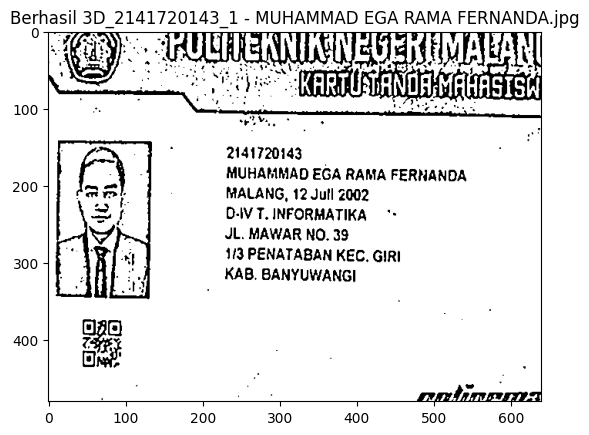

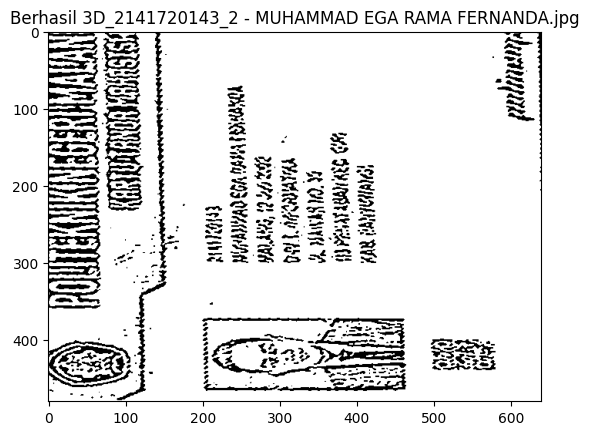

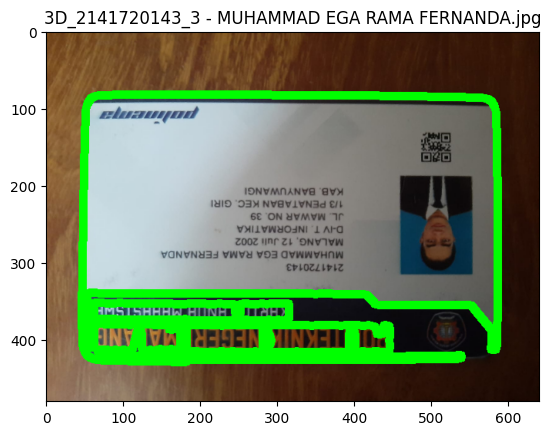

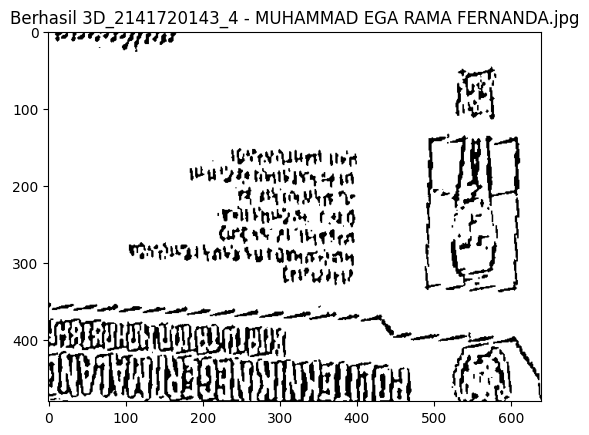

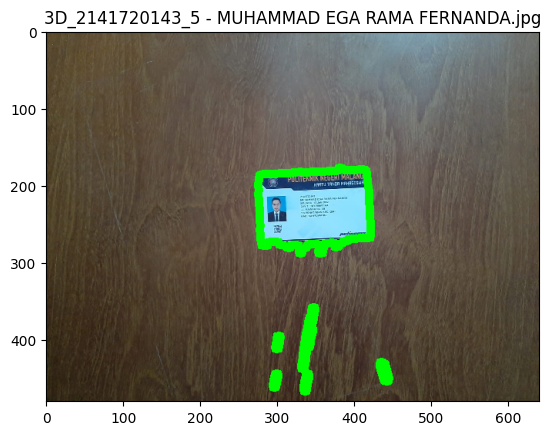

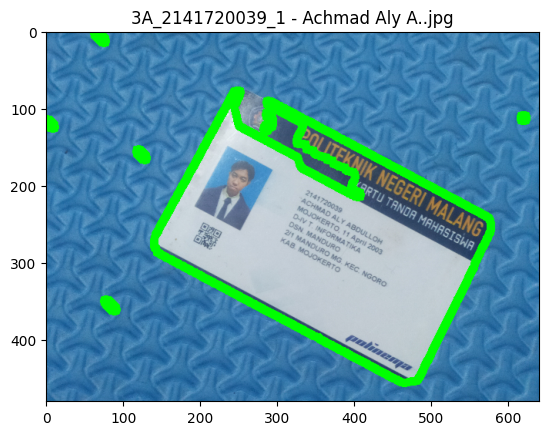

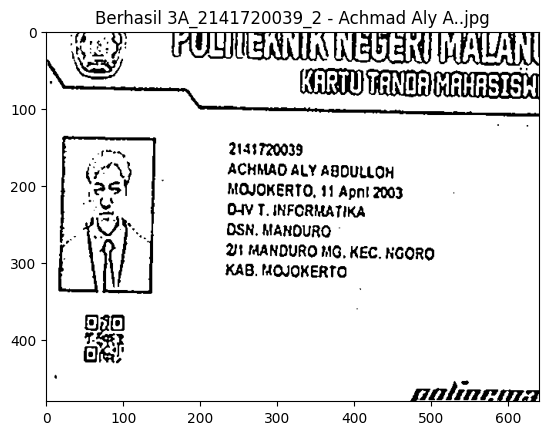

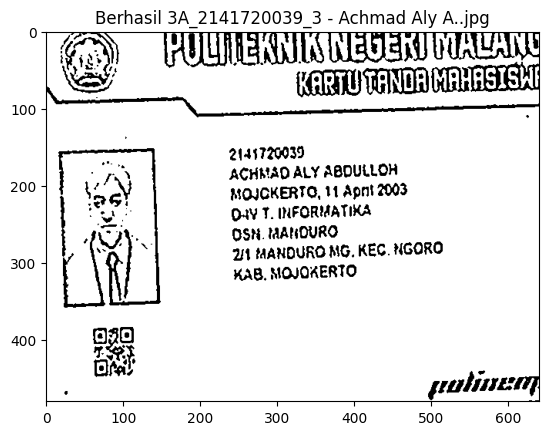

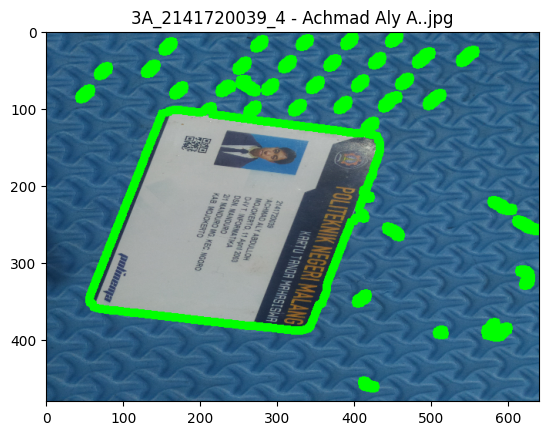

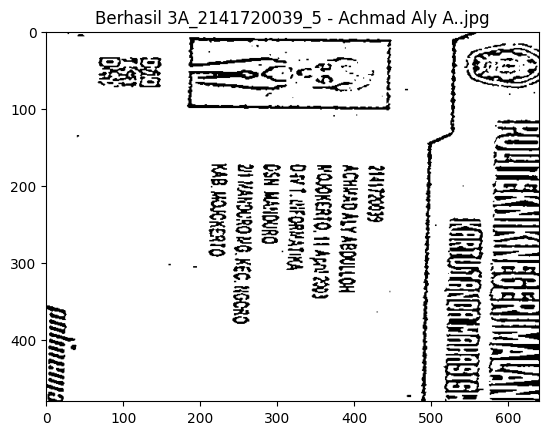

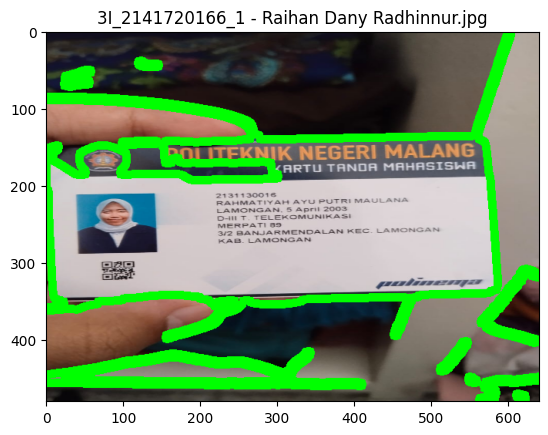

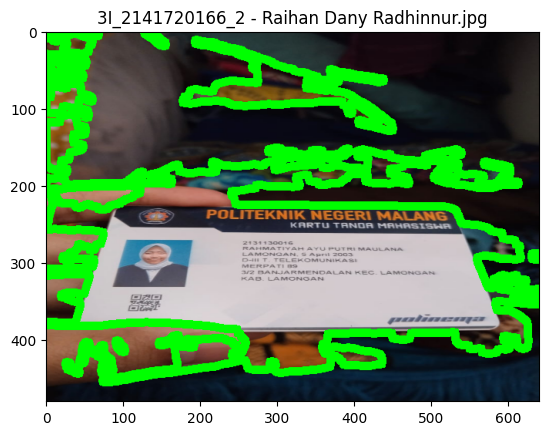

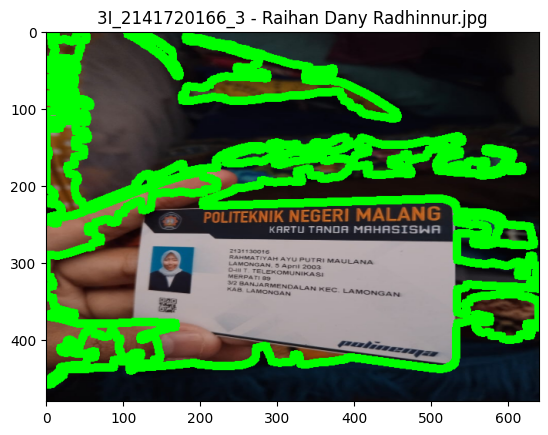

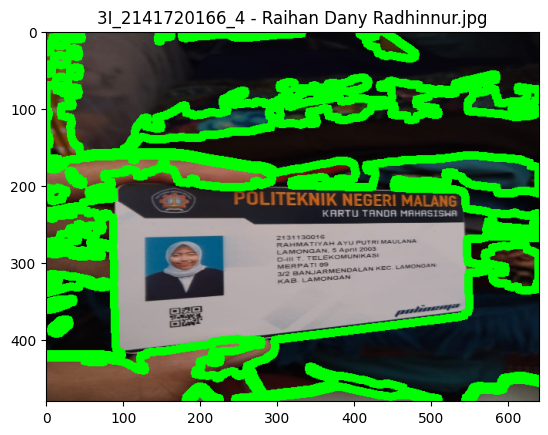

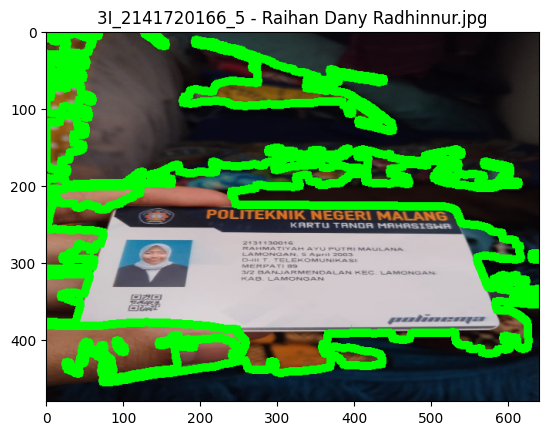

In [4]:
successful_images = []

for image_file in image_files:
  image_path = os.path.join(directory, image_file)
  def nothing(x):
    pass

  def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
      area = cv2.contourArea(i)
      if area > 5000:
        peri = cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
          biggest = approx
          max_area = area
    return biggest, max_area

  def drawRectangle(img,biggest,thickness):
      cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
      cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

  def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

  widthImg = 640
  heightImg = 480
  img = cv2.imread(image_path)
  img = cv2.resize(img,(widthImg, heightImg))
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)

  median = np.median(imgBlur)

  # Set lower and upper thresholds based on the median value
  lower_threshold = int(max(0, 0.7 * median))
  upper_threshold = int(min(255, 1.3 * median))
  imgThreshold = cv2.Canny(imgBlur, lower_threshold, upper_threshold)
  kernel = np.ones((5,5))
  imgDilation = cv2.dilate(imgThreshold, kernel, iterations=2)
  imgThreshold = cv2.erode(imgDilation, kernel, iterations=1)
  imgContours = img.copy()
  imgBigContour = img.copy()
  contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(imgContours, contours, -1, (0,255,0), 10)

  biggest, maxArea = biggestContour(contours)
  if biggest.size != 0:
    biggest = reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0,255,0), 20)
    imgBigContour = drawRectangle(imgBigContour, biggest, 2)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
    # kurangi 20pixel setiap sisi
    imgWarpColored = imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored, (widthImg, heightImg))
    #adaptive threshold
    imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
    imgAdaptiveThre = cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    imgAdaptiveThre = cv2.medianBlur(imgAdaptiveThre,3)

    successful_images.append(imgAdaptiveThre)

    plt.figure()
    imgAdaptiveThre_rgb = cv2.cvtColor(imgAdaptiveThre, cv2.COLOR_GRAY2RGB)
    plt.imshow(imgAdaptiveThre_rgb)
    plt.title('Berhasil '+image_file)

  else:
    plt.figure()
    imgContours_rgb = cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB)
    plt.imshow(imgContours_rgb)
    plt.title(image_file)
plt.show()

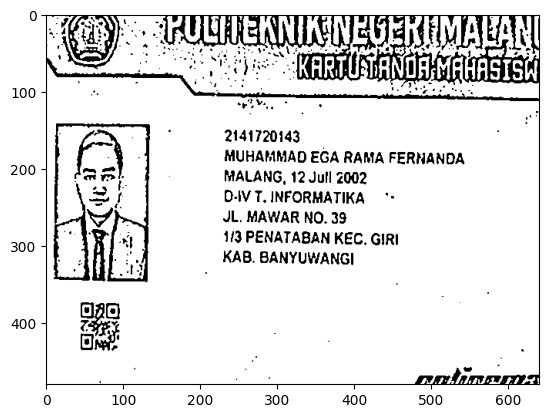

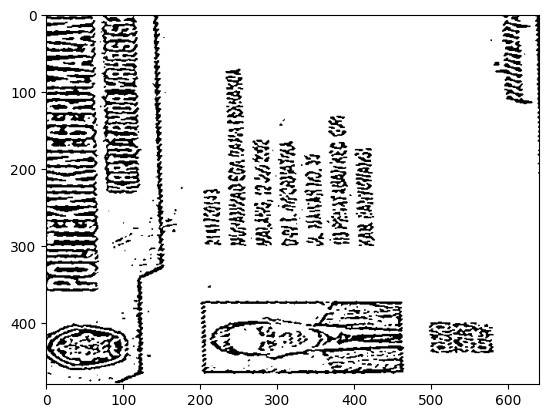

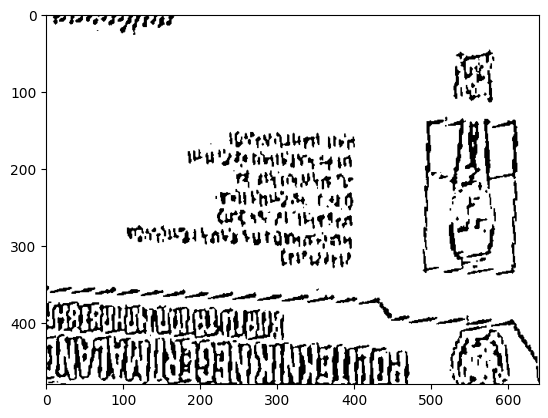

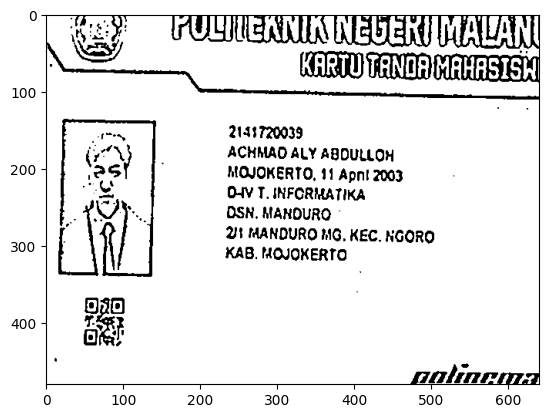

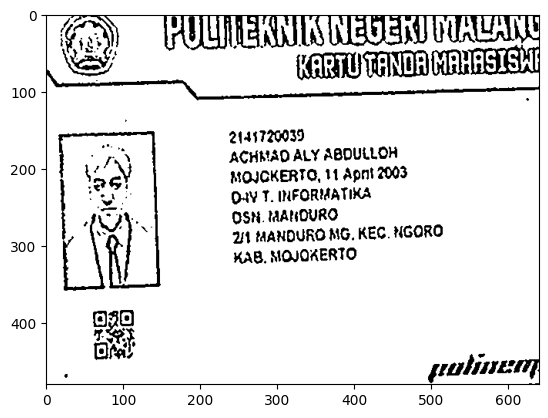

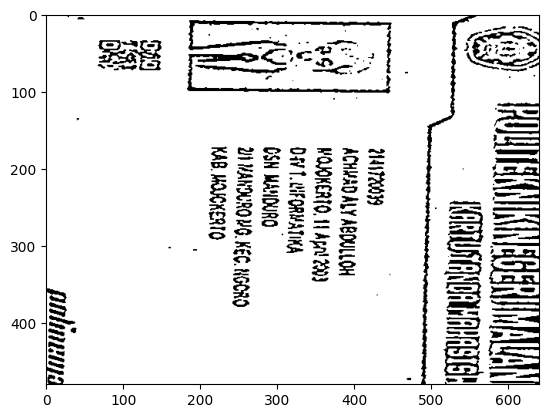

In [5]:
for success in successful_images:
  plt.figure()
  success_rgb = cv2.cvtColor(success, cv2.COLOR_GRAY2RGB)
  plt.imshow(success_rgb)
  plt.show()

# **CNN MODEL**

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
(train_data.shape, test_data.shape)
(train_labels.shape, test_labels.shape)
train_data[0].shape
train_labels.shape

11490434/11490434 [==============================] - 1s 0us/step


(60000,)

Text(0.5, 1.0, 'Class: 8')

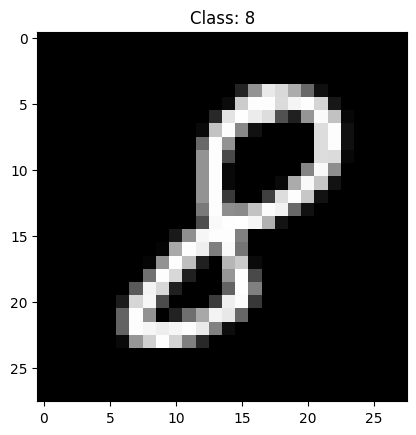

In [8]:
digits_data = np.vstack([train_data, test_data])
digits_labels = np.hstack([train_labels, test_labels])
digits_data.shape
digits_labels.shape

idx = np.random.randint(0, digits_data.shape[0])
plt.imshow(digits_data[idx], cmap='gray')
plt.title('Class: ' + str(digits_labels[idx]))

<Axes: xlabel='Labels', ylabel='count'>

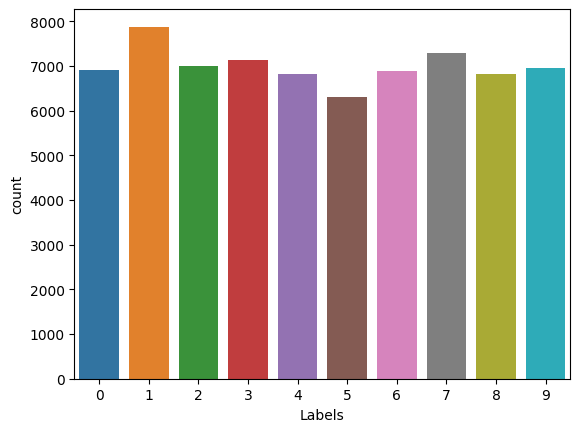

In [9]:
df_labels = pd.DataFrame(digits_labels, columns=['Labels'])
sns.countplot(df_labels, x='Labels')

## **Load Kaggle**

In [10]:
!wget https://iaexpert.academy/arquivos/alfabeto_A-Z.zip

--2023-12-11 03:42:28--  https://iaexpert.academy/arquivos/alfabeto_A-Z.zip
Resolving iaexpert.academy (iaexpert.academy)... 162.159.134.42
Connecting to iaexpert.academy (iaexpert.academy)|162.159.134.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193643888 (185M) [application/zip]
Saving to: ‘alfabeto_A-Z.zip’

alfabeto_A-Z.zip    100%[===================>] 184.67M  61.6MB/s    in 3.0s    

2023-12-11 03:42:32 (61.6 MB/s) - ‘alfabeto_A-Z.zip’ saved [193643888/193643888]



In [11]:
zip_object = zipfile.ZipFile(file = 'alfabeto_A-Z.zip', mode = 'r')
zip_object.extractall('./')
zip_object.close()

dataset_az = pd.read_csv('A_Z Handwritten Data.csv').astype('float32')
dataset_az

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372446,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372447,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372448,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Get pixel data only
alphabet_data = dataset_az.drop('0', axis=1)
# Get labels only
alphabet_labels = dataset_az['0']

# Check shape data
alphabet_data.shape, alphabet_labels.shape

# Check shape labels
alphabet_labels.shape

# Reshape pixel data to 28*28
alphabet_data = np.reshape(alphabet_data.values, (alphabet_data.shape[0], 28, 28))
# Check the result by its shape
alphabet_data.shape

(372450, 28, 28)

Text(0.5, 1.0, 'Class: 14.0')

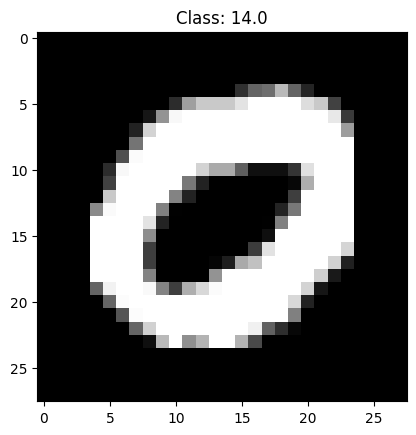

In [13]:
# Randomly checking A-Z dataset
index = np.random.randint(0, alphabet_data.shape[0])
plt.imshow(alphabet_data[index], cmap = 'gray')
plt.title('Class: ' + str(alphabet_labels[index]))

<Axes: xlabel='Labels', ylabel='count'>

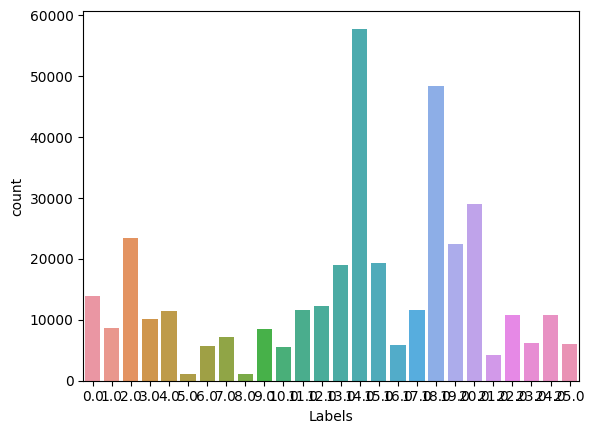

In [14]:
# Check data distribution
df_az_labels = pd.DataFrame({
    'Labels': alphabet_labels.values
})
sns.countplot(df_az_labels, x='Labels')

In [15]:
# Check unique value from digits_labels
np.unique(digits_labels)

# Check unique value from alphabet_labels
np.unique(alphabet_labels)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
      dtype=float32)

In [16]:
# check alphabet labels again
np.unique(alphabet_labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
      dtype=float32)

In [17]:
# Combine both of them
data = np.vstack([alphabet_data, digits_data])
labels = np.hstack([alphabet_labels, digits_labels])

# Check the shape
data.shape, labels.shape

((442450, 28, 28), (442450,))

In [18]:
# Check labels
np.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.],
      dtype=float32)

In [19]:
# Convert data to float32
data = np.array(data, dtype = 'float32')

# Since Convolutional need 3d data (including depth)
# and our images only in 2d data (because in grayscale format)
# we need to add "the depth" to the data
data = np.expand_dims(data, axis=-1)

# check shape
data.shape

(442450, 28, 28, 1)

## **Pre-Processing**

In [20]:
# Normalize data
data /= 255.0

# Check range value of data
data[0].min(), data[0].max()

(0.0, 1.0)

In [21]:
# Enconde the labels
# LabelBinarizer similar with OneHotEncoder
le = LabelBinarizer()
labels = le.fit_transform(labels)

# Check labels shape
labels.shape

(442450, 26)

Text(0.5, 1.0, '[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]')

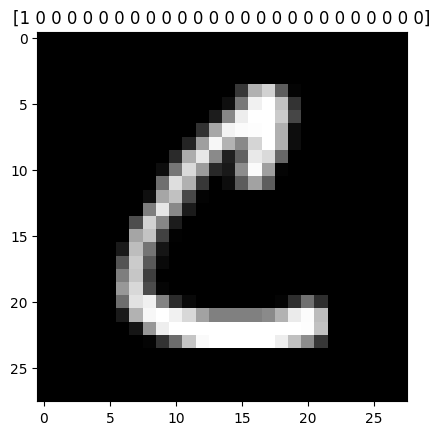

In [22]:
# Check data with label binarizer's label
plt.imshow(data[30000].reshape(28,28), cmap='gray')
plt.title(str(labels[0]))

In [23]:
# Since our data is not balance, we will handle it by giving weight for 'small' data

# Check number of data for each labels first
classes_total = labels.sum(axis = 0)
classes_total

array([20772, 16545, 30399, 17275, 18264,  7476, 12638, 14511,  7945,
       15451,  5603, 11586, 12336, 19010, 57825, 19341,  5812, 11566,
       48419, 22495, 29008,  4182, 10784,  6272, 10859,  6076])

In [24]:
# Check the biggest value of data
classes_total.max()

57825

In [25]:
# Create a weight for each data
classes_weights = {}
for i in range(0, len(classes_total)):
  #print(i)
  classes_weights[i] = classes_total.max() / classes_total[i]

# Check the weight for each data
classes_weights

{0: 2.783795493934142,
 1: 3.4950135992747056,
 2: 1.9022007302871804,
 3: 3.3473227206946454,
 4: 3.1660643889618925,
 5: 7.734751203852327,
 6: 4.575486627630954,
 7: 3.984908000826959,
 8: 7.278162366268093,
 9: 3.7424762151317066,
 10: 10.320364090665715,
 11: 4.990937338166753,
 12: 4.6875,
 13: 3.0418200946870066,
 14: 1.0,
 15: 2.989762680316426,
 16: 9.94924294562973,
 17: 4.999567698426422,
 18: 1.1942625828703608,
 19: 2.5705712380529007,
 20: 1.993415609487038,
 21: 13.827116212338593,
 22: 5.362110534124629,
 23: 9.21954719387755,
 24: 5.3250759738465785,
 25: 9.51695194206715}

## **Split data to train and test**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 1, stratify = labels)

## **Create data augmentation**

In [27]:
# Import library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(rotation_range = 10, zoom_range=0.05, width_shift_range=0.1,
                                  height_shift_range=0.1, horizontal_flip = False)

## **Build CNN Model**

In [28]:
# Import library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
# Build the network
network = Sequential()

network.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='same'))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters = 128, kernel_size=(3,3), activation='relu', padding='valid'))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Flatten())

network.add(Dense(64, activation = 'relu'))
network.add(Dense(128, activation = 'relu'))

# output
network.add(Dense(36, activation='softmax'))

network.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [30]:
# Check network summary
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [31]:
# Create actual labels
name_labels = '0123456789'
name_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
name_labels = [l for l in name_labels]

# Check actual label
print(name_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [32]:
import joblib

joblib.dump(name_labels, "labels.pkl")

['labels.pkl']

In [33]:
a = joblib.load("labels.pkl")
print(a)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## **Train Model**

In [38]:
# Set model name, epoch, and batch size
file_model = 'custom_ocr.model'
epochs = 20
batch_size = 128

In [39]:
# Setup checkpoint
checkpointer = ModelCheckpoint(file_model, monitor = 'val_loss', verbose = 1, save_best_only=True)

In [40]:
# Fit the model
history = network.fit(augmentation.flow(X_train, y_train, batch_size=batch_size),
                      validation_data = (X_test, y_test),
                      steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                      class_weight = classes_weights, verbose=1, callbacks=[checkpointer])

Epoch 1/20


InvalidArgumentError: ignored

## **Evaluate Model**

### **Make a single prediction**

In [ ]:
# make a prediction
predictions = load_network.predict(X_test, batch_size=batch_size)

In [ ]:
# Check prediction for data-0
# You will get the probability for each label
# The highest one is the prediction
predictions[10]

In [ ]:
# Get the actual prediction -> highest probability
np.argmax(predictions[10])

In [ ]:
# Check label for 24
name_labels[28]

In [ ]:
# Check y_test label for 0
y_test[10]

In [ ]:
# check the highest value
np.argmax(y_test[10])

In [ ]:
# Check the label of y_test 0
name_labels[np.argmax(y_test[10])]

### **make an Evaluation on Test Data**

In [ ]:
# Evaluate on test data
load_network.evaluate(X_test, y_test)

In [ ]:
# Print Classification Report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = name_labels))

In [ ]:
# Visualize loss value for each epoch
plt.plot(history.history['val_loss'])

In [ ]:
# You can also check the another metrics
history.history.keys()

In [ ]:
# Check the model performance by validation accuracy
plt.plot(history.history['val_accuracy'])

### **Save the Model**

In [ ]:
# The result will show in colab directory
network.save('network', save_format= 'h5')

### **Testing on Real Image**

In [ ]:
# Import library
from tensorflow.keras.models import load_model

In [ ]:
# Load saved network
load_network = load_model('network')

In [ ]:
# Check summary
load_network.summary()

In [ ]:
# Load Image
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('b_capital.png')
cv2_imshow(img)

In [ ]:
# Check shape
img.shape

In [ ]:
# Convert to gray
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# check shape
gray_img.shape

In [ ]:
# Pre-process
# Binary Threshold and Otsu
value, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

cv2_imshow(thresh)

# print threshold value
print(value)

In [ ]:
# Resize image in order to match network input shape -> 28*28
img_resize = cv2.resize(gray_img, (28,28))
cv2_imshow(img_resize)

In [ ]:
img_resize.shape

In [ ]:
# Convert to float 32
# and extend the dimension since network input shape is 28*28*1
img_input = img_resize.astype('float32') / 255 # also perform normalization
img_input = np.expand_dims(img_input, axis=-1) # insert depth

# check shape
img_input.shape

In [ ]:
# Add "amount of data" as dimension
img_input = np.reshape(img_input, (1,28,28,1))
img_input.shape

In [ ]:
# Make a predition
prediction = load_network.predict(img_input)
pred_label = np.argmax(prediction) # predict actual label
pred_label

In [ ]:
# check label for 6
name_labels[11]